# Recitation 7 - RDD

In [10]:
import stata_setup
import pandas as pd
stata_setup.config("/Applications/STATA","se")

## • Basic RDD

In [11]:
%%stata
* Let's create some data to illustrate
clear
capture log close
set obs 1000 // this tells stata to generate 1000 observations when creating variables
set seed 1234567


. * Let's create some data to illustrate
. clear

. capture log close

. set obs 1000 // this tells stata to generate 1000 observations when creating 
> variables
Number of observations (_N) was 0, now 1,000.

. set seed 1234567

. 


In [12]:
%%stata

* Generate running variable. Stata code attributed to Marcelo Perraillon. Thanks, Marcelo.
gen x = rnormal(50, 25) // Generates random values from a normal distribution with mean = 50, SD = 25
replace x=0 if x < 0 
drop if x > 100
sum x, det



. 
. * Generate running variable. Stata code attributed to Marcelo Perraillon. Tha
> nks, Marcelo.
. gen x = rnormal(50, 25) // Generates random values from a normal distribution
>  with mean = 50, SD = 25

. replace x=0 if x < 0 
(24 real changes made)

. drop if x > 100
(11 observations deleted)

. sum x, det

                              x
-------------------------------------------------------------
      Percentiles      Smallest
 1%            0              0
 5%     7.581868              0
10%     17.55611              0       Obs                 989
25%     32.95432              0       Sum of wgt.         989

50%     50.69007                      Mean           49.34681
                        Largest       Std. dev.      23.25304
75%     65.28811        99.0975
90%     80.07679       99.70067       Variance       540.7037
95%     88.76378       99.97297       Skewness      -.0798667
99%     96.25841       99.97885       Kurtosis        2.44414

. 


In [13]:
%%stata

* Set the cutoff at X=50. Treated if X > 50
gen D = 0
replace D = 1 if x > 50
gen y1 = 25 + 0*D + 1.5*x + rnormal(0, 20) // Note here that we are mechanically making the treatment have 0 effect 




. 
. * Set the cutoff at X=50. Treated if X > 50
. gen D = 0

. replace D = 1 if x > 50
(504 real changes made)

. gen y1 = 25 + 0*D + 1.5*x + rnormal(0, 20) // Note here that we are mechanica
> lly making the treatment have 0 effect 

. 
. 


In [ ]:
%%stata

* Potential outcome Y1 not jumping at cutoff (continuity)
twoway (scatter y1 x if D==0, msize(vsmall) msymbol(circle_hollow)) /// 
    (scatter y1 x if D==1, sort  msize(vsmall) msymbol(circle_hollow)) ///
    (lfit y1 x if D==0, lcolor(red) msize(small) lwidth(medthin) lpattern(solid)) /// 
    (lfit y1 x if D==1, lcolor(red) msize(small)   lwidth(medthin) lpattern(solid)) ///
    (lfit y1 x, lcolor(dknavy) msize(small) lwidth(medthin) lpattern(dash)), ///
    xtitle(Test score (X)) xline(50) legend(off)



. 
. 
. * Let's create an actual shift
. gen y = 25 + 40*D + 1.5*x + rnormal(0, 20)

. 
. twoway (scatter y x if D==0, msize(vsmall) ) (scatter y x if D==1, sort msize
> (vsmall) ) ///
>     (lfit y x if D==0, lcolor(red) msize(small)   lwidth(medthin) lpattern(so
> lid)) /// 
>     (lfit y x if D==1, lcolor(red) msize(small)   lwidth(medthin) lpattern(so
> lid)) ///
>     (lfit y1 x, lcolor(dknavy) msize(small) lwidth(medthin) lpattern(dash)) ,
>  xtitle(Test score (X)) /// 
>     xline(50) legend(off)

. 


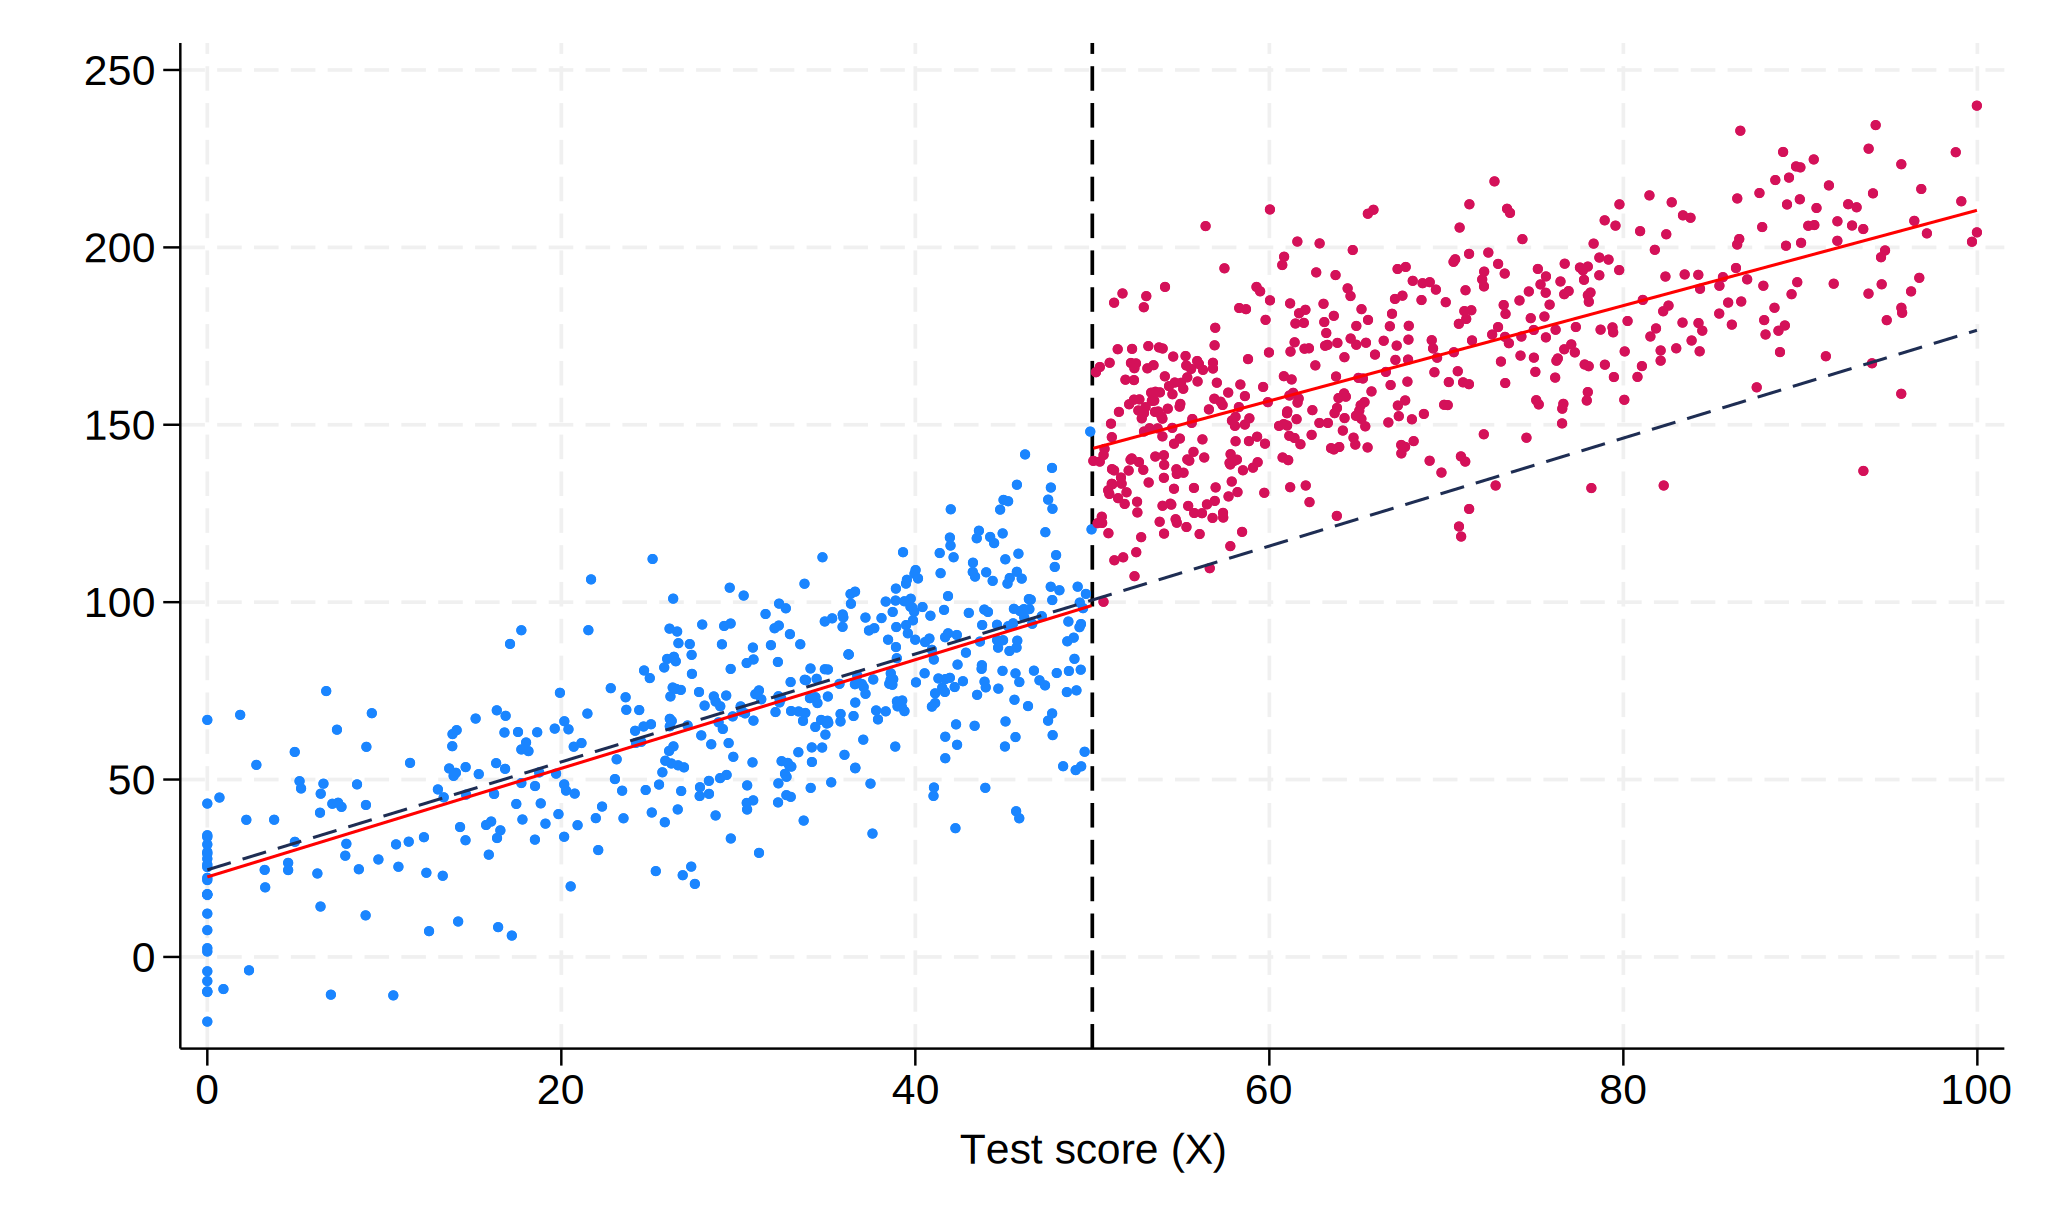

In [14]:
%%stata


* Let's create an actual shift
gen y = 25 + 40*D + 1.5*x + rnormal(0, 20)

twoway (scatter y x if D==0, msize(vsmall) ) (scatter y x if D==1, sort msize(vsmall) ) ///
    (lfit y x if D==0, lcolor(red) msize(small)   lwidth(medthin) lpattern(solid)) /// 
    (lfit y x if D==1, lcolor(red) msize(small)   lwidth(medthin) lpattern(solid)) ///
    (lfit y1 x, lcolor(dknavy) msize(small) lwidth(medthin) lpattern(dash)) , xtitle(Test score (X)) /// 
    xline(50) legend(off)


. 
. // Quicly, let's just re-center the running variable (common practice)
. gen x_center = x - 50

. 
. twoway (scatter y x_center if D==0, msize(vsmall) ) (scatter y x_center if D=
> =1, sort msize(vsmall)) ///
>     (lfit y x_center if D==0, lcolor(red) msize(small)   lwidth(medthin) lpat
> tern(solid)) ///
>     (lfit y x_center if D==1, lcolor(red) msize(small)   lwidth(medthin) lpat
> tern(solid)) ///
>     (lfit y1 x_center, lcolor(dknavy) msize(small) lwidth(medthin) lpattern(d
> ash)) ///
>     , xtitle(Test score (X)) xline(50) legend(off)

. 


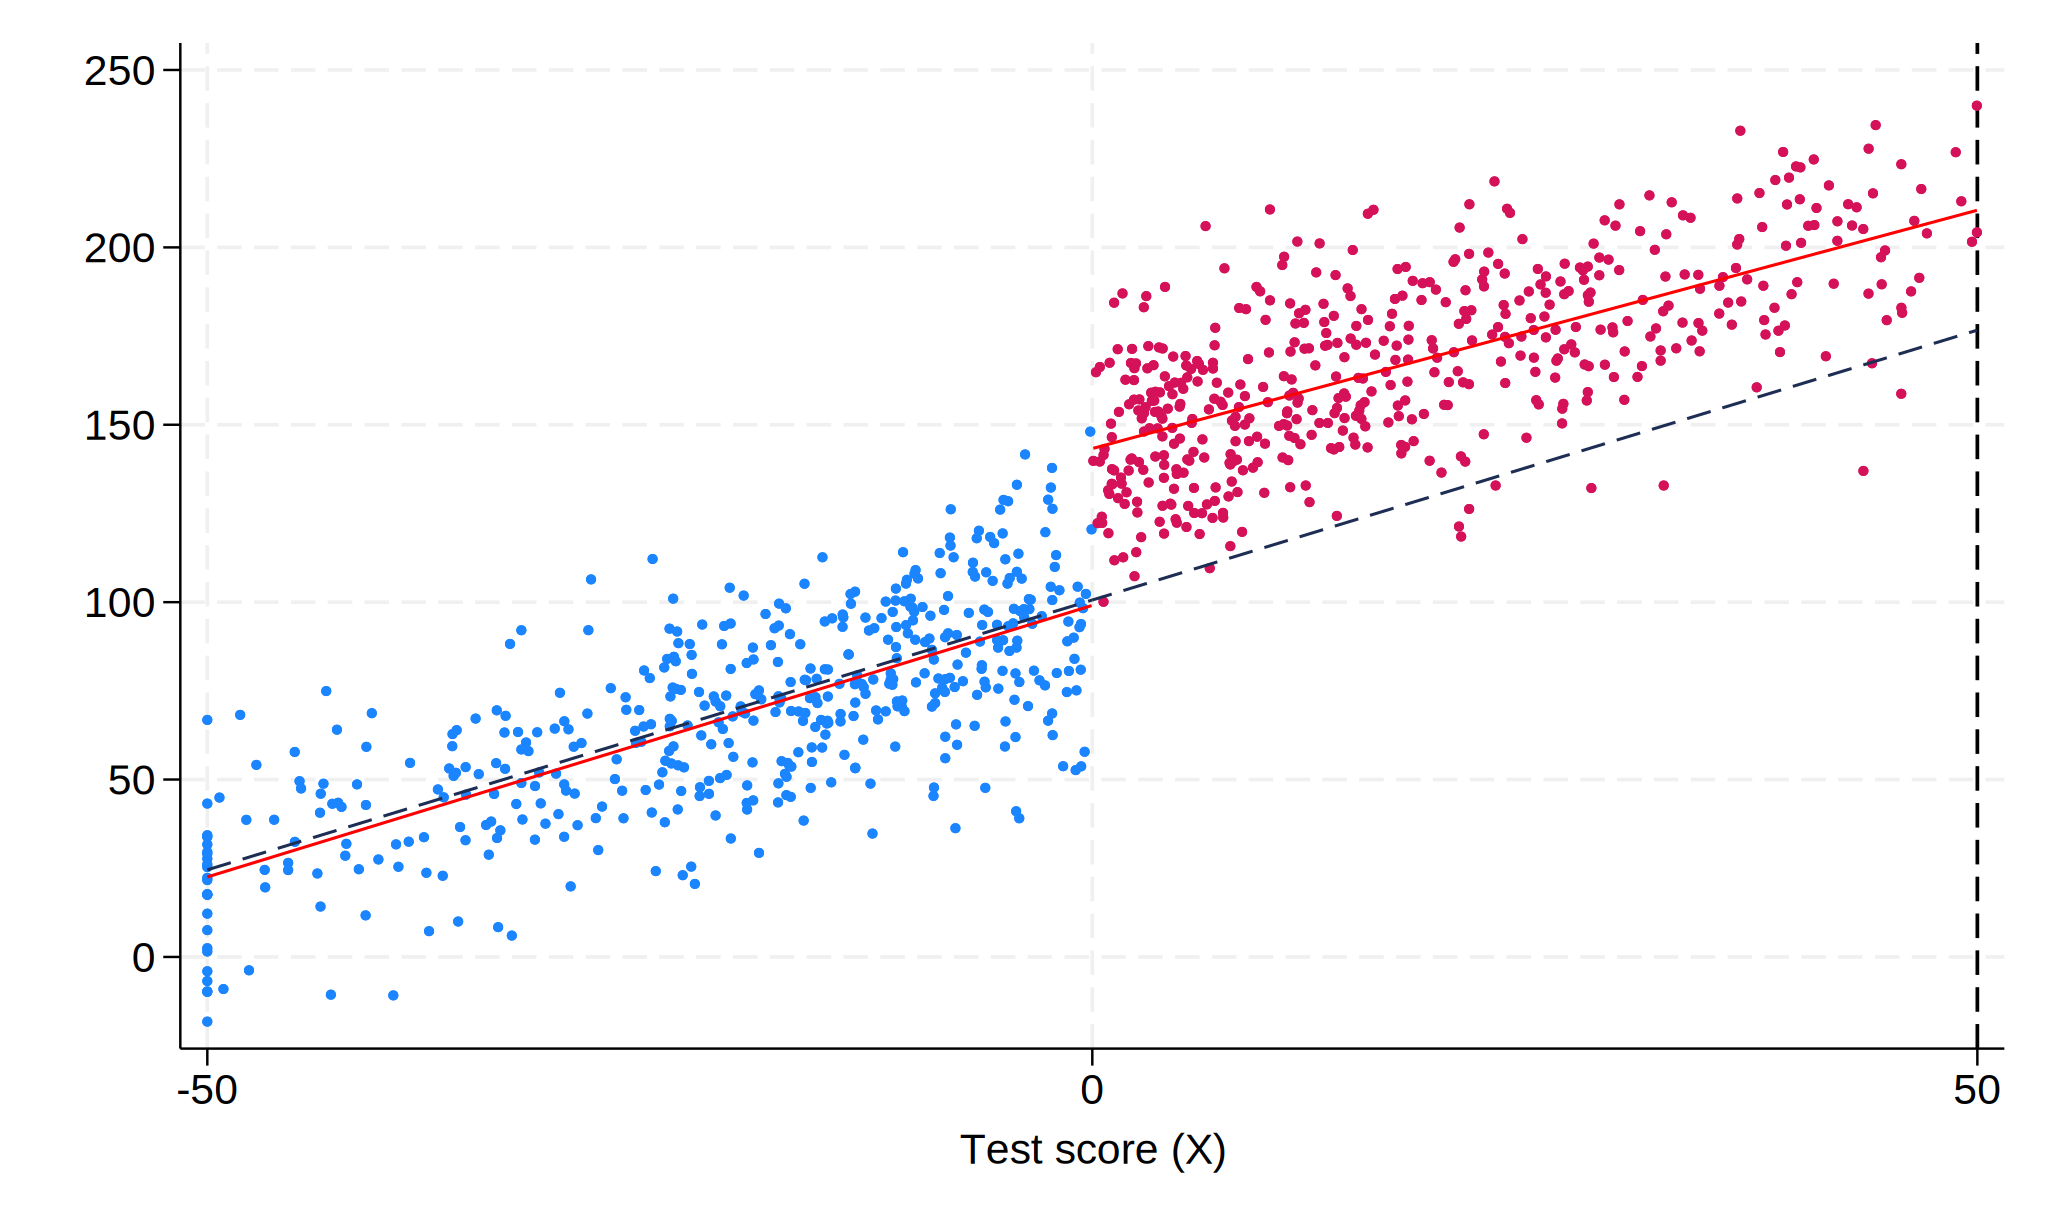

In [15]:
%%stata

// Quicly, let's just re-center the running variable (common practice)
gen x_center = x - 50

twoway (scatter y x_center if D==0, msize(vsmall) ) (scatter y x_center if D==1, sort msize(vsmall)) ///
    (lfit y x_center if D==0, lcolor(red) msize(small)   lwidth(medthin) lpattern(solid)) ///
    (lfit y x_center if D==1, lcolor(red) msize(small)   lwidth(medthin) lpattern(solid)) ///
    (lfit y1 x_center, lcolor(dknavy) msize(small) lwidth(medthin) lpattern(dash)) ///
    , xtitle(Test score (X)) xline(50) legend(off)


In [16]:
%%stata


// How can we estimate the RD coefficient?

// Simplest way is to just estimate the treatment effect with a dummy
reg y x D  , robust



. 
. 
. // How can we estimate the RD coefficient?
. 
. // Simplest way is to just estimate the treatment effect with a dummy
. reg y x D  , robust

Linear regression                               Number of obs     =        989
                                                F(2, 986)         =    3652.05
                                                Prob > F          =     0.0000
                                                R-squared         =     0.8807
                                                Root MSE          =     19.565

------------------------------------------------------------------------------
             |               Robust
           y | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
           x |   1.440498   .0480704    29.97   0.000     1.346166     1.53483
           D |   44.27807   2.227397    19.88   0.000     39.90709    48.64905
       _cons |   25.266

In [17]:
%%stata


// But we could also account for the fact that the slopes might be different on either side of the cutoff (DiD)
reg y c.x##D, robust


. 
. 
. // But we could also account for the fact that the slopes might be different 
> on either side of the cutoff (DiD)
. reg y c.x##D, robust

Linear regression                               Number of obs     =        989
                                                F(3, 985)         =    2457.58
                                                Prob > F          =     0.0000
                                                R-squared         =     0.8812
                                                Root MSE          =     19.535

------------------------------------------------------------------------------
             |               Robust
           y | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
           x |   1.530506   .0687527    22.26   0.000     1.395587    1.665425
         1.D |   53.56889    5.08346    10.54   0.000     43.59324    63.54455
             |
       D#c

In [18]:
%%stata


// Or we could look around the cutoff and estimate the treatment effect in a DiD fashion
reg y c.x##D if x>=40 & x<=60 , robust


. 
. 
. // Or we could look around the cutoff and estimate the treatment effect in a 
> DiD fashion
. reg y c.x##D if x>=40 & x<=60 , robust

Linear regression                               Number of obs     =        318
                                                F(3, 314)         =     200.51
                                                Prob > F          =     0.0000
                                                R-squared         =     0.6586
                                                Root MSE          =     20.589

------------------------------------------------------------------------------
             |               Robust
           y | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
           x |   .9918495   .6930729     1.43   0.153    -.3718046    2.355504
         1.D |   38.71038   43.15377     0.90   0.370    -46.19673    123.6175
             |
       D#c.x |


In [19]:
%%stata


//But how can we get the coefficient that exactly matches the figure?
*** Manually estimating/storing coefficient (extrapolating)

scalar drop _all

qui reg y x if D == 0, robust
scalar b1 = _b[x]
scalar cons1 = _b[_cons]
scalar se_1 = _se[x]
scalar se_cons_1 = _se[_cons]

qui reg y x if D == 1 , robust 
scalar b2 = _b[x]
scalar cons2 = _b[_cons]
scalar se_2 = _se[x]
scalar se_cons_2 = _se[_cons]

scalar rdd_wrong = cons2 - cons1 // Why is this wrong? But also, not that wrong?

scalar rdd_coef = cons2 + b2*50 - cons1 - b1*50
scalar se_coef = (se_cons_2^2 + (se_2^2)*(50^2) + se_cons_1^2 + (se_1^2)*(50^2) )^(1/2)
scalar t_coef = rdd_coef/se_coef

scalar list



. 
. 
. //But how can we get the coefficient that exactly matches the figure?
. *** Manually estimating/storing coefficient (extrapolating)
. 
. scalar drop _all

. 
. qui reg y x if D == 0, robust

. scalar b1 = _b[x]

. scalar cons1 = _b[_cons]

. scalar se_1 = _se[x]

. scalar se_cons_1 = _se[_cons]

. 
. qui reg y x if D == 1 , robust 

. scalar b2 = _b[x]

. scalar cons2 = _b[_cons]

. scalar se_2 = _se[x]

. scalar se_cons_2 = _se[_cons]

. 
. scalar rdd_wrong = cons2 - cons1 // Why is this wrong? But also, not that wro
> ng?

. 
. scalar rdd_coef = cons2 + b2*50 - cons1 - b1*50

. scalar se_coef = (se_cons_2^2 + (se_2^2)*(50^2) + se_cons_1^2 + (se_1^2)*(50^
> 2) )^(1/2)

. scalar t_coef = rdd_coef/se_coef

. 
. scalar list
    t_coef =  6.3436407
   se_coef =  6.9707303
  rdd_coef =  44.219809
 rdd_wrong =  53.568893
 se_cons_2 =   4.576861
      se_2 =  .06612854
     cons2 =  76.131057
        b2 =  1.3435243
 se_cons_1 =  2.2119437
      se_1 =  .06875543
     cons1 =  22.56

In [20]:
%%stata

// But really, in practice we'll use:
ssc install rdrobust

rdrobust y x, c(50) p(2) kernel(triangular) // Triangular kernel is the default,
                                            //but I wanted to include so you could see the options


. 
. // But really, in practice we'll use:
. ssc install rdrobust
checking rdrobust consistency and verifying not already installed...
all files already exist and are up to date.

. 
. rdrobust y x, c(50) p(2) kernel(triangular) // Triangular kernel is the defau
> lt,

Sharp RD estimates using local polynomial regression.

     Cutoff c = 50 | Left of c  Right of c            Number of obs =        98
> 9
-------------------+----------------------            BW type       =      mser
> d
     Number of obs |       485         504            Kernel        = Triangula
> r
Eff. Number of obs |       216         257            VCE method    =         N
> N
    Order est. (p) |         2           2
    Order bias (q) |         3           3
       BW est. (h) |    15.345      15.345
       BW bias (b) |    20.693      20.693
         rho (h/b) |     0.742       0.742

Outcome: y. Running variable: x.
-------------------------------------------------------------------------------
> -
     

In [22]:
%%stata

rdrobust y x, c(50) p(1) kernel(uniform) 

rdrobust y x_center, p(1) kernel(epa)



. 
. rdrobust y x, c(50) p(1) kernel(uniform) 



Sharp RD estimates using local polynomial regression.

     Cutoff c = 50 | Left of c  Right of c            Number of obs =        98
> 9
-------------------+----------------------            BW type       =      mser
> d
     Number of obs |       485         504            Kernel        =    Unifor
> m
Eff. Number of obs |       136         177            VCE method    =         N
> N
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |     9.844       9.844
       BW bias (b) |    18.622      18.622
         rho (h/b) |     0.529       0.529

Outcome: y. Running variable: x.
-------------------------------------------------------------------------------
> -
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval
> ]
-------------------+-----------------------------------------------------------
> -
      Conventional |  46.149     5.0816   9.0815   0.000    36.1889      56.108
> 5
            Robust |   


. 
. // To check if there was any manipulation around the cutoff:
. // net install rddensity, from(https://sites.google.com/site/rdpackages/rdden
> sity/stata) replace
. // net install lpdensity, from(https://sites.google.com/site/nppackages/lpden
> sity/stata) replace
. rddensity x, c(50) plot
Computing data-driven bandwidth selectors.

Point estimates and standard errors have been adjusted for repeated observation
> s.
(Use option nomasspoints to suppress this adjustment.)

RD Manipulation test using local polynomial density estimation.

     c =    50.000 | Left of c  Right of c          Number of obs =          98
> 9
-------------------+----------------------          Model         = unrestricte
> d
     Number of obs |       485         504          BW method     =         com
> b
Eff. Number of obs |       204         267          Kernel        =   triangula
> r
    Order est. (p) |         2           2          VCE method    =    jackknif
> e
    Order bias (q) |         3   

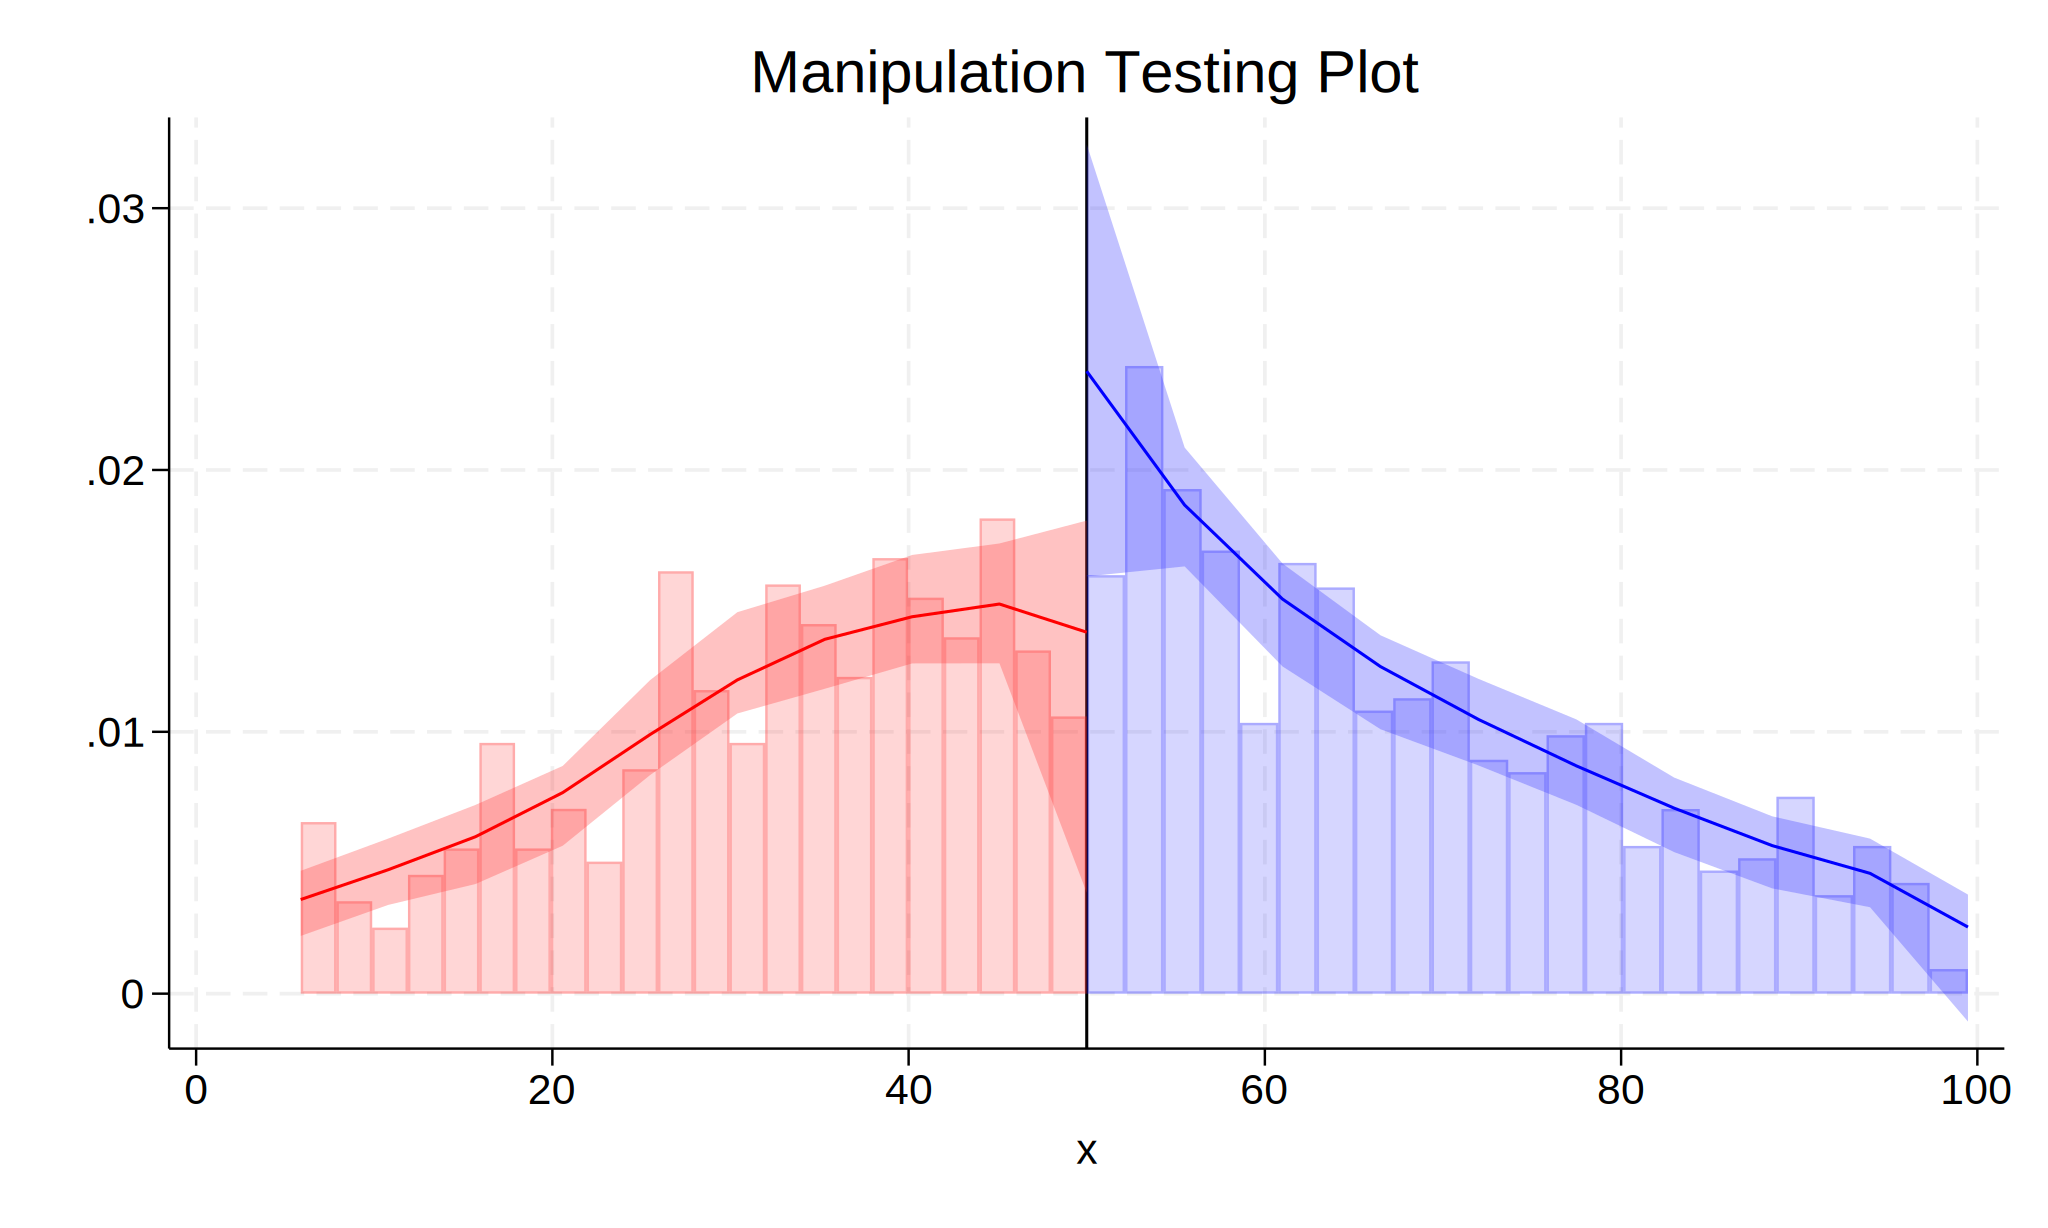

In [23]:
%%stata

// To check if there was any manipulation around the cutoff:
// net install rddensity, from(https://sites.google.com/site/rdpackages/rddensity/stata) replace
// net install lpdensity, from(https://sites.google.com/site/nppackages/lpdensity/stata) replace
rddensity x, c(50) plot

## • Nonlinearities

In [24]:
%%stata

// Careful not to confuse nonlinearity for discontinuity

drop y y1 x* D
set obs 1000
gen x = rnormal(100, 50)
replace x=0 if x < 0
drop if x > 280
sum x, det


. 
. // Careful not to confuse nonlinearity for discontinuity
. 
. drop y y1 x* D

. set obs 1000
Number of observations (_N) was 0, now 1,000.

. gen x = rnormal(100, 50)

. replace x=0 if x < 0
(23 real changes made)

. drop if x > 280
(0 observations deleted)

. sum x, det

                              x
-------------------------------------------------------------
      Percentiles      Smallest
 1%            0              0
 5%     16.90887              0
10%     34.73739              0       Obs               1,000
25%     65.31785              0       Sum of wgt.       1,000

50%     101.5725                      Mean           100.6951
                        Largest       Std. dev.      49.29577
75%     131.3326       230.3903
90%     165.7854       242.7144       Variance       2430.073
95%     185.4698       253.3629       Skewness       .1043976
99%     212.5247       257.6595       Kurtosis       2.691343

. 


In [25]:
%%stata


* Set the cutoff at X=140. Treated if X > 140
* Note that we're forcing the treatment effect to be = 0
gen D = 0
replace D = 1 if x > 140
gen x2 = x*x
gen x3 = x*x*x
gen y = 10000 + 0*D - 100*x + x2 + rnormal(0, 1000)
reg y D x // Notice the big and significant coefficient on D


. 
. 
. * Set the cutoff at X=140. Treated if X > 140
. * Note that we're forcing the treatment effect to be = 0
. gen D = 0

. replace D = 1 if x > 140
(209 real changes made)

. gen x2 = x*x

. gen x3 = x*x*x

. gen y = 10000 + 0*D - 100*x + x2 + rnormal(0, 1000)

. reg y D x // Notice the big and significant coefficient on D

      Source |       SS           df       MS      Number of obs   =     1,000
-------------+----------------------------------   F(2, 997)       =   2076.21
       Model |  3.0871e+10         2  1.5436e+10   Prob > F        =    0.0000
    Residual |  7.4122e+09       997  7434492.35   R-squared       =    0.8064
-------------+----------------------------------   Adj R-squared   =    0.8060
       Total |  3.8283e+10       999    38321585   Root MSE        =    2726.6

------------------------------------------------------------------------------
           y | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+---------------------


. 
. 
. scatter y x if D==0, msize(vsmall) || scatter y x ///
>   if D==1, msize(vsmall) legend(off) xline(140, ///
>   lstyle(foreground)) || lfit y x ///
>   if D ==0, color(red) || lfit y x if D ==1, ///
>   color(red) xtitle("Test Score (X)") ///
>   ytitle("Outcome (Y)") 

. 


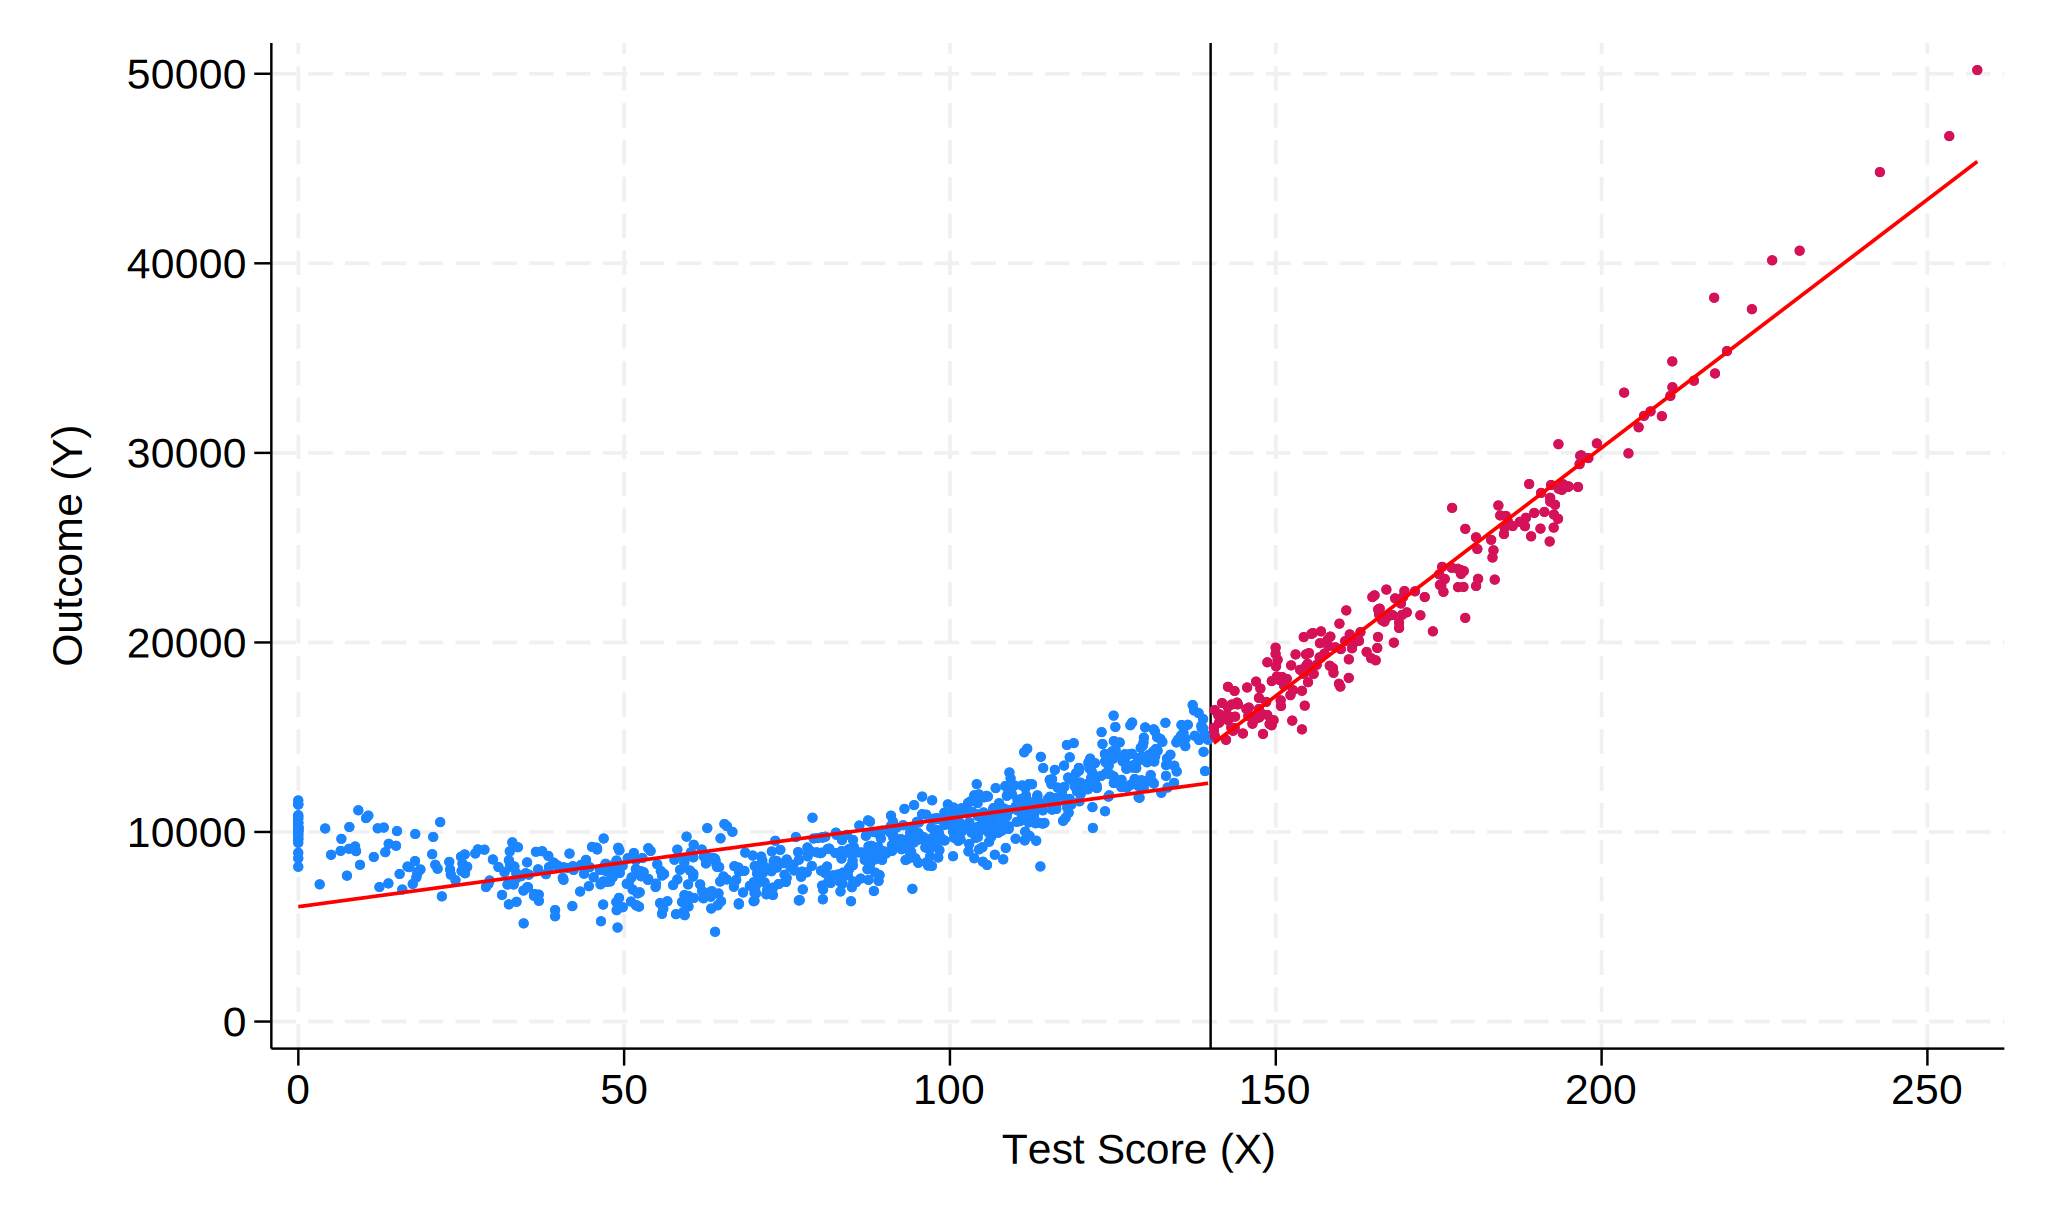

In [26]:
%%stata


scatter y x if D==0, msize(vsmall) || scatter y x ///
  if D==1, msize(vsmall) legend(off) xline(140, ///
  lstyle(foreground)) || lfit y x ///
  if D ==0, color(red) || lfit y x if D ==1, ///
  color(red) xtitle("Test Score (X)") ///
  ytitle("Outcome (Y)") 

In [27]:
%%stata

* Polynomial estimation
reg y D x x2 x3
predict yhat // Running this "predict" command after a regression stores the y-hat values



. 
. * Polynomial estimation
. reg y D x x2 x3

      Source |       SS           df       MS      Number of obs   =     1,000
-------------+----------------------------------   F(4, 995)       =   8743.13
       Model |  3.7224e+10         4  9.3061e+09   Prob > F        =    0.0000
    Residual |  1.0591e+09       995     1064384   R-squared       =    0.9723
-------------+----------------------------------   Adj R-squared   =    0.9722
       Total |  3.8283e+10       999    38321585   Root MSE        =    1031.7

------------------------------------------------------------------------------
           y | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
           D |  -58.67837   150.9692    -0.39   0.698    -354.9329    237.5762
           x |  -103.2073   5.406317   -19.09   0.000    -113.8164   -92.59823
          x2 |   1.040991   .0565049    18.42   0.000     .9301085    1.151873
  


. 
. 
. scatter y x if D==0, msize(vsmall) || scatter y x ///
>   if D==1, msize(vsmall) legend(off) xline(140, ///
>   lstyle(foreground)) ylabel(none) || line yhat x ///
>   if D ==0, color(red) sort || line yhat x if D==1, ///
>   sort color(red) xtitle("Test Score (X)") ///
>   ytitle("Outcome (Y)") 

.   
. 


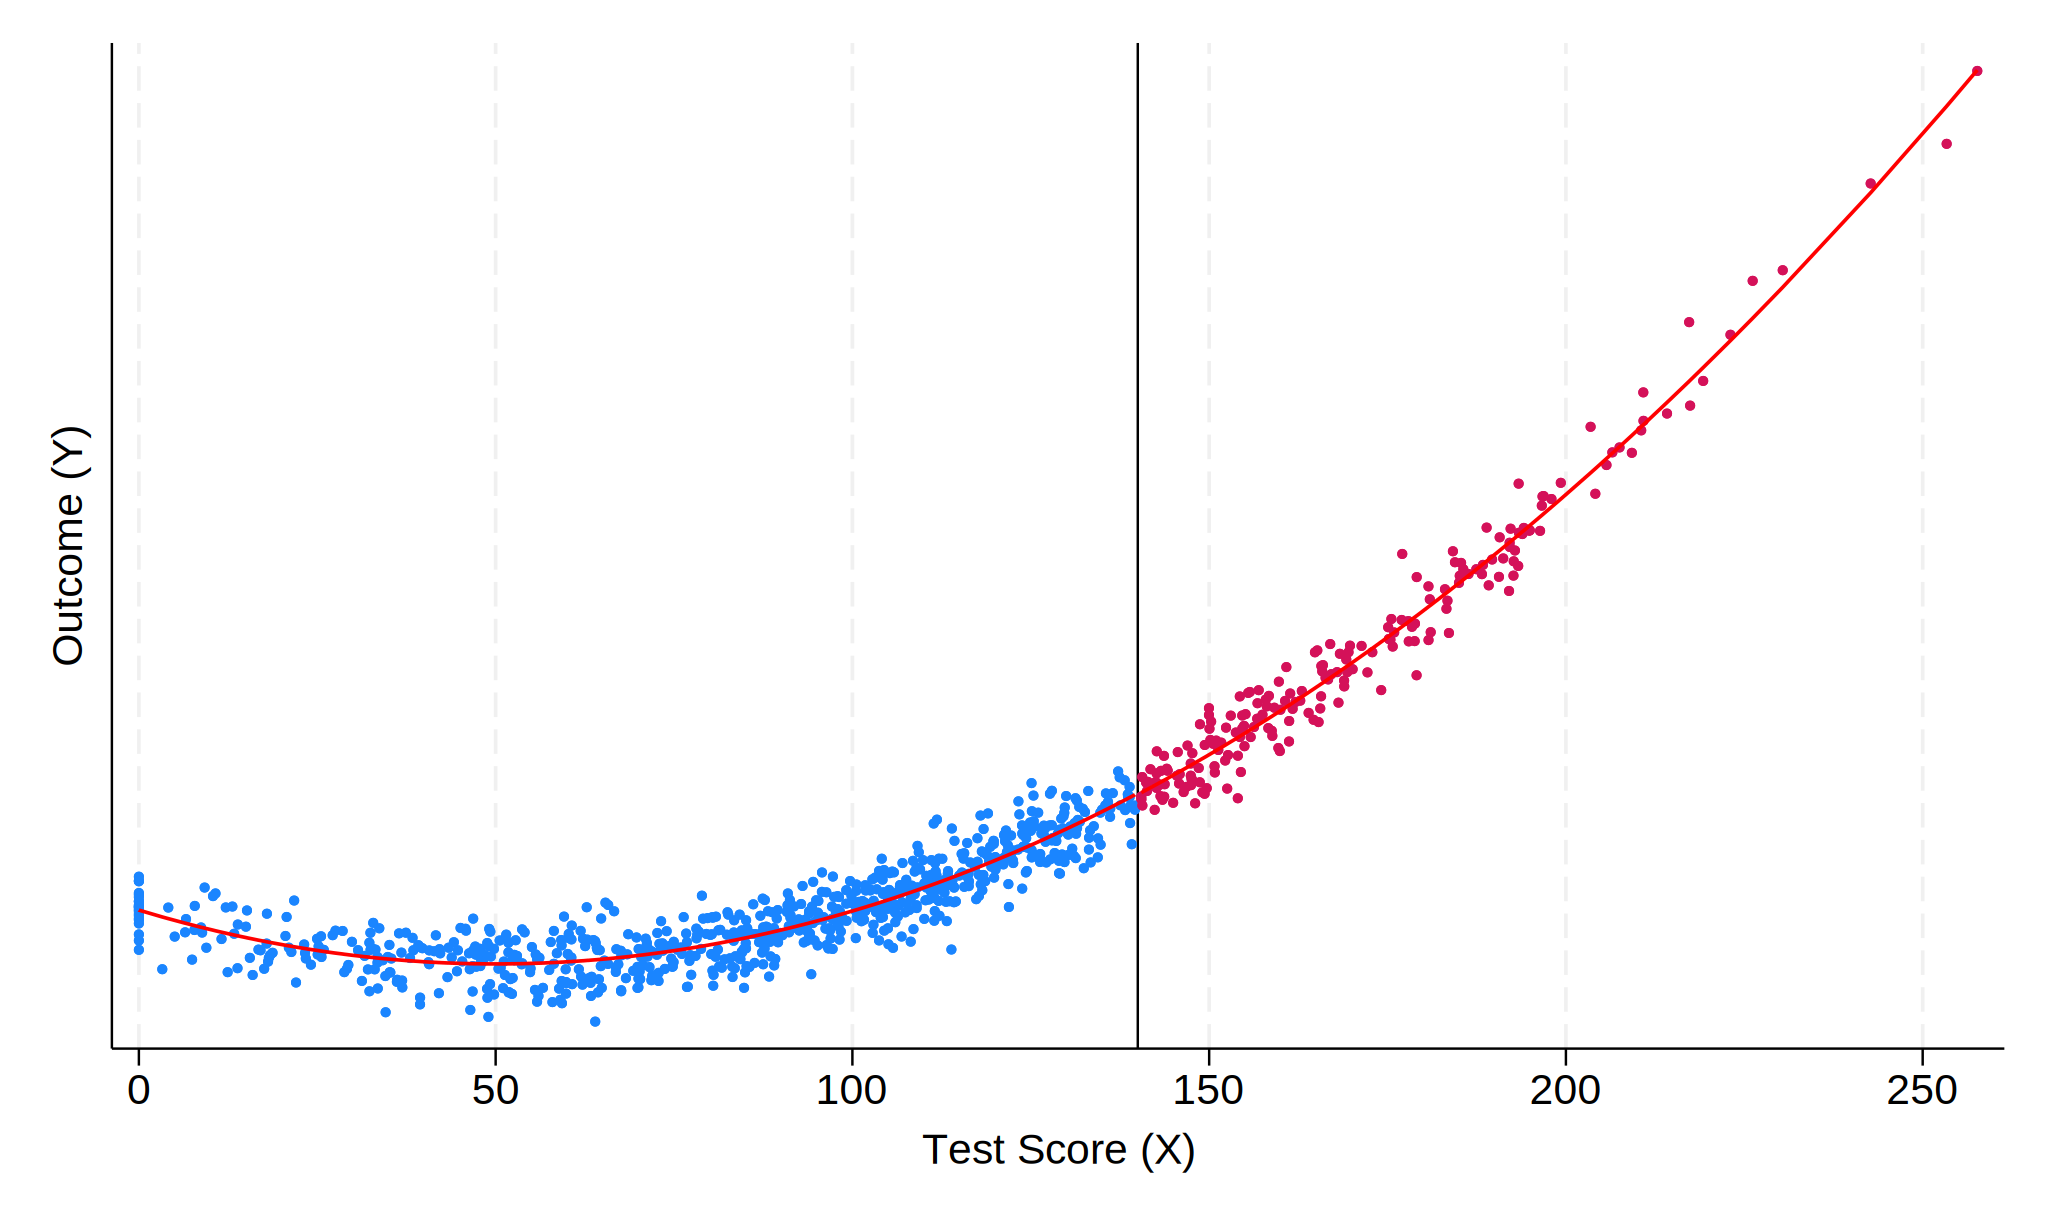

In [28]:
%%stata


scatter y x if D==0, msize(vsmall) || scatter y x ///
  if D==1, msize(vsmall) legend(off) xline(140, ///
  lstyle(foreground)) ylabel(none) || line yhat x ///
  if D ==0, color(red) sort || line yhat x if D==1, ///
  sort color(red) xtitle("Test Score (X)") ///
  ytitle("Outcome (Y)") 
  


. set seed 1234567

. 
. capture drop y yhat

. gen y = 10000 + 0*D - 100*x +x2 + rnormal(0, 1000)

. reg y D##c.(x x2 x3)

      Source |       SS           df       MS      Number of obs   =     1,000
-------------+----------------------------------   F(7, 992)       =   5448.69
       Model |  3.7134e+10         7  5.3049e+09   Prob > F        =    0.0000
    Residual |   965815385       992  973604.219   R-squared       =    0.9747
-------------+----------------------------------   Adj R-squared   =    0.9745
       Total |  3.8100e+10       999  38138035.7   Root MSE        =    986.71

------------------------------------------------------------------------------
           y | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
         1.D |   3800.504   19015.97     0.20   0.842    -33515.63    41116.64
           x |  -99.54202   8.976588   -11.09   0.000    -117.1573   -81.92674
     

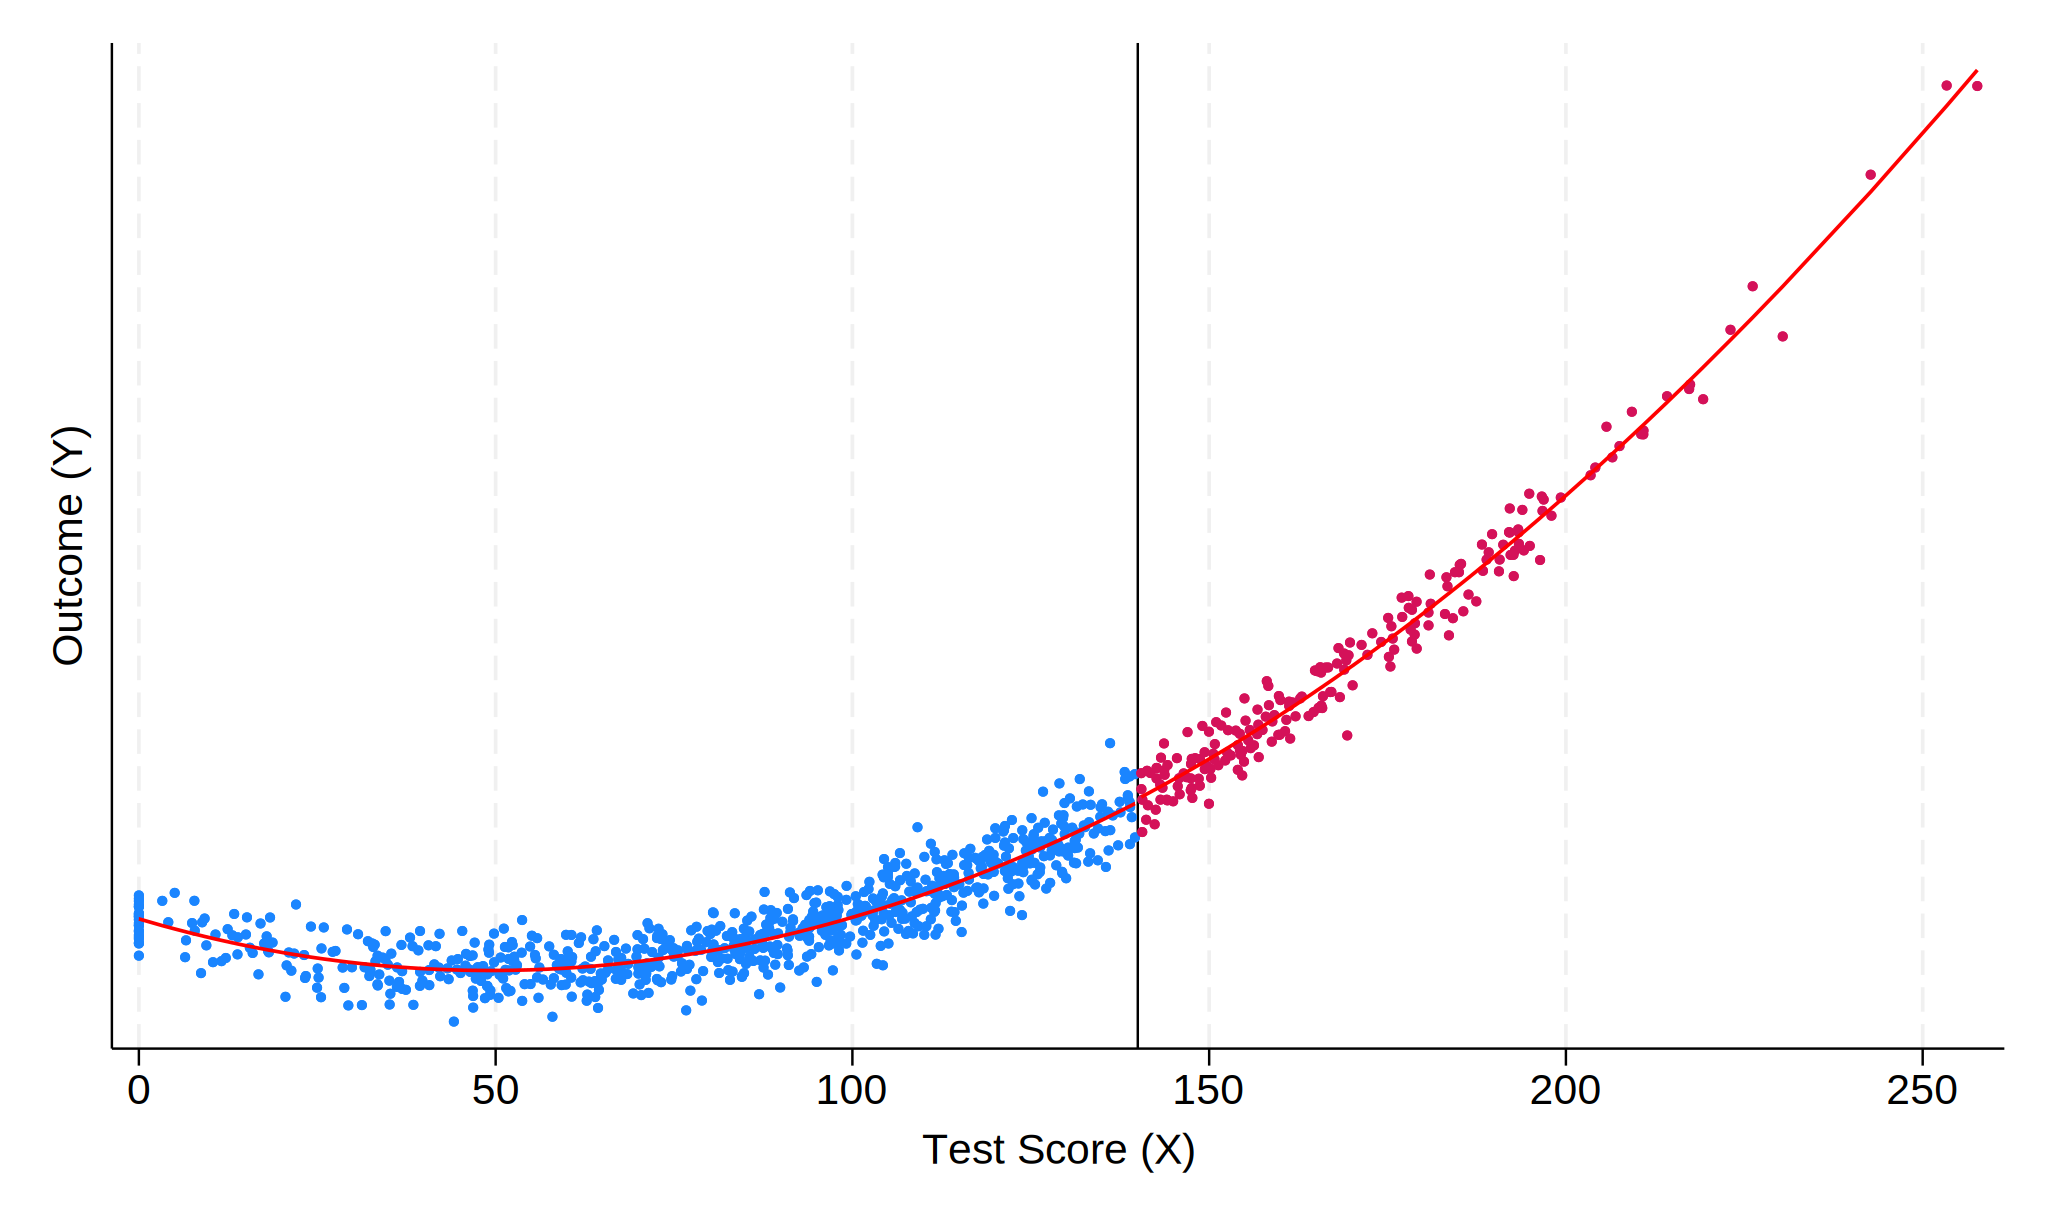

In [29]:
%%stata
set seed 1234567

capture drop y yhat
gen y = 10000 + 0*D - 100*x +x2 + rnormal(0, 1000)
reg y D##c.(x x2 x3)
predict yhat

scatter y x if D==0, msize(vsmall) || scatter y x ///
  if D==1, msize(vsmall) legend(off) xline(140, ///
  lstyle(foreground)) ylabel(none) || line yhat x ///
  if D ==0, color(red) sort || line yhat x if D==1, ///
  sort color(red) xtitle("Test Score (X)") ///
  ytitle("Outcome (Y)") 

In [30]:
%%stata

rdrobust y x, c(140) p(4)


. 
. rdrobust y x, c(140) p(4)

Sharp RD estimates using local polynomial regression.

    Cutoff c = 140 | Left of c  Right of c            Number of obs =       100
> 0
-------------------+----------------------            BW type       =      mser
> d
     Number of obs |       791         209            Kernel        = Triangula
> r
Eff. Number of obs |       466         190            VCE method    =         N
> N
    Order est. (p) |         4           4
    Order bias (q) |         5           5
       BW est. (h) |    61.466      61.466
       BW bias (b) |    76.090      76.090
         rho (h/b) |     0.808       0.808

Outcome: y. Running variable: x.
-------------------------------------------------------------------------------
> -
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval
> ]
-------------------+-----------------------------------------------------------
> -
      Conventional |  69.809     516.57   0.1351   0.893    -942.65      10

In [31]:
%%stata

rdbwselect y x , c(140) // This is SUPER important. Bandwidth selection is the most important choice you make with RDD.


. 
. rdbwselect y x , c(140) // This is SUPER important. Bandwidth selection is th
> e most important choice you make with RDD.

Bandwidth estimators for sharp RD local polynomial regression.

       Cutoff c =  | Left of c  Right of c            Number of obs =       100
> 0
-------------------+----------------------            Kernel        = Triangula
> r
     Number of obs |       791         209            VCE method    =         N
> N
          Min of x |     0.000     140.489
          Max of x |   139.609     257.660
    Order est. (p) |         1           1
    Order bias (q) |         2           2

Outcome: y. Running variable: x.
-------------------------------------------------------------------------------
> -
                   |         BW est. (h)          |        BW bias (b)
            Method | Left of c         Right of c | Left of c        Right of c
-------------------+------------------------------+----------------------------
> -
             mserd |    33.09


. 
. rdplot y x, c(140)

RD Plot with evenly spaced mimicking variance number of bins using spacings est
> imators.

       Cutoff c = 140 | Left of c  Right of c        Number of obs  =       100
> 0
----------------------+----------------------        Kernel         =    Unifor
> m
        Number of obs |       791         209
   Eff. Number of obs |       791         209
  Order poly. fit (p) |         4           4
     BW poly. fit (h) |   140.000     117.660
 Number of bins scale |     1.000       1.000

Outcome: y. Running variable: x.
---------------------------------------------
                      | Left of c  Right of c
----------------------+----------------------
        Bins selected |       111         167
   Average bin length |     1.261       0.705
    Median bin length |     1.261       0.705
----------------------+----------------------
    IMSE-optimal bins |        28          19
  Mimicking Var. bins |       111         167
----------------------+-------------

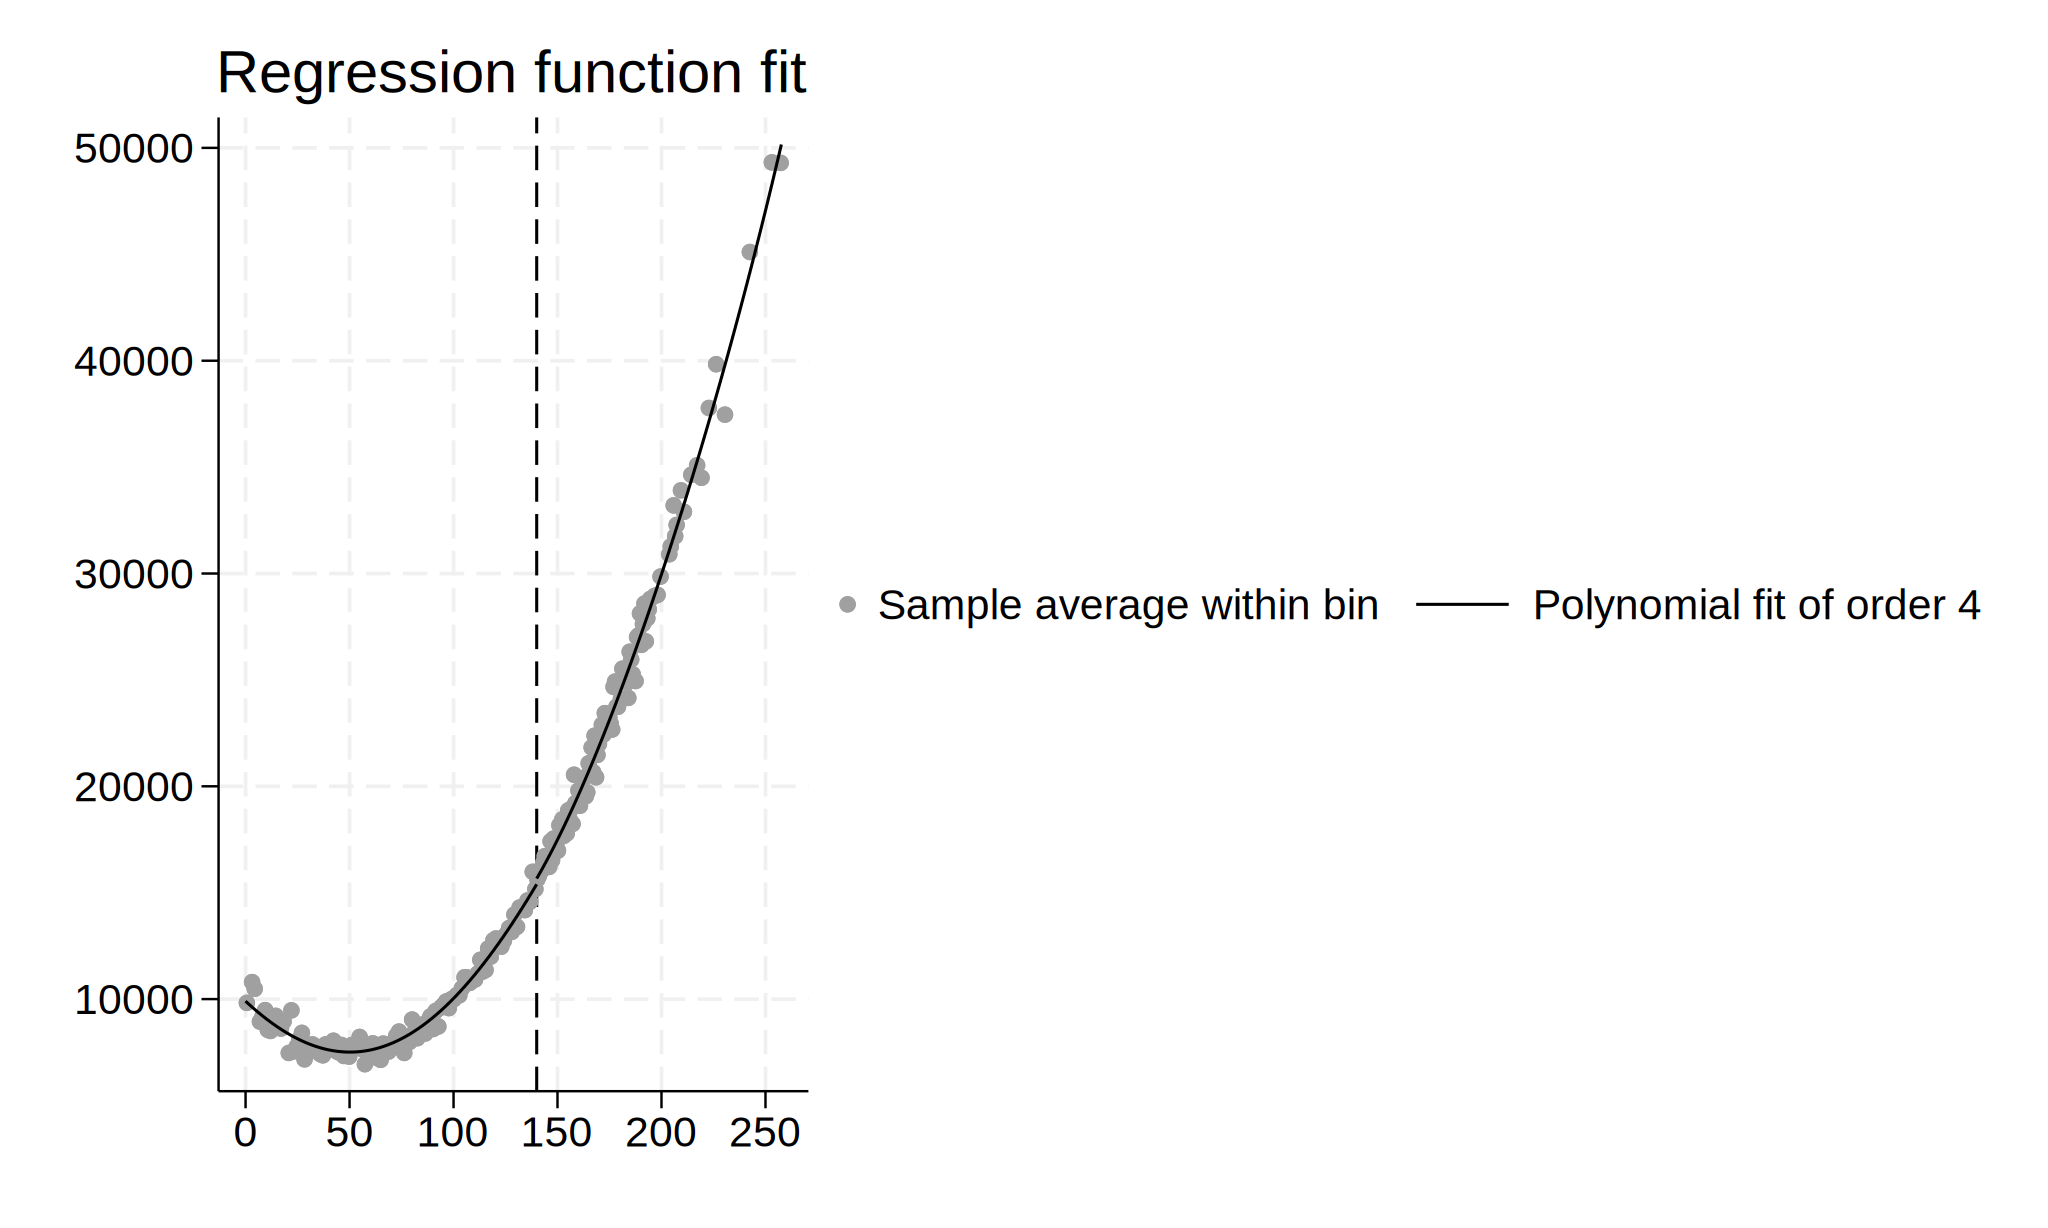

In [32]:
%%stata

rdplot y x, c(140)

## • Exercise

In [ ]:
%%stata

// Paper "Do Voters Affect or Elect Policies? Evidence from the U. S. House" by 
// Lee, David S. ; Moretti, Enrico ; Butler, Matthew J.
// link: https://pitt.primo.exlibrisgroup.com/discovery/fulldisplay?docid=cdi_crossref_primary_10_1162_0033553041502153&context=PC&vid=01PITT_INST:01PITT_INST&lang=en&search_scope=MyInst_and_CI&adaptor=Primo%20Central&tab=Everything&query=any,contains,Do%20Voters%20Affect%20or%20Elect%20Policies%3F%20Evidence%20from%20the%20U.%20S.%20House&offset=0

use https://github.com/scunning1975/mixtape/raw/master/lmb-data.dta, clear

scatter score lagdemvoteshare 

In [ ]:
%%stata

* Replicating Table 1 of Lee, Moretti and Butler (2004)
// In this analysis, we want to look at the effects around the cutoff
// we're regressing the score of the policy on a dummy for democrat won in the prior period
// The score is a measure of how much a policy is aligned with the democratic agenda. (higher means more democrat)
// the variable democrat is just an indicator for whether a democrat won in the prior period

// Here "eststo" stores the estimation you're running under some name, here "r1"
eststo r1: reg score lagdemocrat    if lagdemvoteshare>.48 & lagdemvoteshare<.52, cluster(id) 



In [ ]:
%%stata

// we're regressing the score of the policy on a dummy for democrat won in this eriod
eststo r2: reg score democrat       if lagdemvoteshare>.48 & lagdemvoteshare<.52, cluster(id)


In [ ]:
%%stata

// here we're regressing whether a democrat won this period on whether they won last period
eststo r3: reg democrat lagdemocrat if lagdemvoteshare>.48 & lagdemvoteshare<.52, cluster(id)

In [ ]:
%%stata

// Then we can use "esttab" to compile the estimates we stored (this appends the 
// estimates sequentially on the right)

esttab r1 r2 r3 , se sfmt(3) b( 3) se(3) star(* 0.10 ** 0.05 *** 0.01) ///
keep( lagdemocrat democrat ) ///
scalars("N Observations")   
// So this table is what we're going to work towards from now on.


In [ ]:
%%stata

// To do:

* 1. Use all the data to estimate the effects (on the score for the election period), 
* not just around the cutoff and see how the results compare

// What if we use all the data? Not just around the cutoff?
reg score lagdemocrat, cluster(id)
reg score democrat, cluster(id)
reg democrat lagdemocrat, cluster(id)

In [ ]:
%%stata

* 2. Control for the running variable and see how that affects the resutls

// Let's try controlling for the running variable?
// Also, let's recenter the running variable
gen demvoteshare_c = demvoteshare - 0.5
reg score lagdemocrat demvoteshare_c, cluster(id)
reg score democrat demvoteshare_c, cluster(id)
reg democrat lagdemocrat demvoteshare_c, cluster(id)

In [ ]:
%%stata

* 3. Allow the running variable to have a different coefficient on either side of the discontinuity

// What if we let the running variable vary on either side of the discontinuity?

xi: reg score i.lagdemocrat*demvoteshare_c, cluster(id)

// or reg score lagdemocrat##c.demvoteshare_c, cluster(id) 
// notice that c.demvoteshare_c creates an interaction between a contunious variable and a dummy variable

// the xi: allows us to convert categorical variables to dummy variables

xi: reg score i.democrat*demvoteshare_c, cluster(id)
xi: reg democrat i.lagdemocrat*demvoteshare_c, cluster(id)

In [ ]:
%%stata

* 4. Use a quadratic transformation of the runing variable to account for potential nonlinearities

// What if we use a quadratic?
gen demvoteshare_sq = demvoteshare_c^2
xi: reg score lagdemocrat##c.(demvoteshare_c demvoteshare_sq), cluster(id)
xi: reg score democrat##c.(demvoteshare_c demvoteshare_sq), cluster(id)
xi: reg democrat lagdemocrat##c.(demvoteshare_c demvoteshare_sq), cluster(id)

In [ ]:
%%stata

* 5. Re-do step 4, but this time considering only observations within 5% of 
// the running variable cutoff, which is 50%


// let's try using a 5pp window now
xi: reg score lagdemocrat##c.(demvoteshare_c demvoteshare_sq) ///
    if lagdemvoteshare>.45 & lagdemvoteshare<.55, cluster(id)
xi: reg score democrat##c.(demvoteshare_c demvoteshare_sq) ///
    if lagdemvoteshare>.45 & lagdemvoteshare<.55, cluster(id)
xi: reg democrat lagdemocrat##c.(demvoteshare_c demvoteshare_sq) ///
    if lagdemvoteshare>.45 & lagdemvoteshare<.55, cluster(id)

In [ ]:
%%stata

* 6. Use rdrobust and rdplot to check if the results in the paper are close to what they should be 
// (assuming the non-parametric method gives the correct answer)

rdrobust score lagdemvoteshare, c(0.5) 
rdplot score lagdemvoteshare, c(0.5)


In [ ]:
%%stata

rdrobust score demvoteshare, c(0.5)
rdplot score demvoteshare, c(0.5)


In [ ]:
%%stata


rdrobust democrat lagdemvoteshare, c(0.5)
rdplot democrat lagdemvoteshare, c(0.5)

In [ ]:
%%stata

* 7. Use rddensity to check if there was any manipulation around the cutoff.

rddensity lagdemvoteshare, c(0.5) plot


## Just because

In [ ]:
%%stata

* Stata code attributed to Marcelo Perraillon.
*ssc install cmogram
cmogram score lagdemvoteshare, cut(0.5) scatter line(0.5) qfitci


In [ ]:
%%stata


cmogram score lagdemvoteshare, cut(0.5) scatter line(0.5) lfit


In [ ]:
%%stata

cmogram score lagdemvoteshare, cut(0.5) scatter line(0.5) lowess